## Example 05 - Basic Hopper Operation on Route

**Example description:** Example of a trailing suction hopper dredge shipping sediment from origin to destination site while following a graph for sailing full and sailing empty.

* [**0. Import required libraries:**](#0.-Import-required-libraries)<br>
* [**1. Define work method:**](#1.-Define-work-method)<br>
   * [**1.1 Sites:**](#1.1-Define-the-project-sites)<br>
   * [**1.2 Equipment:**](#1.2-Define-the-project-equipment)<br>
   * [**1.3 Activities:**](#1.3-Define-the-activity)<br>
* [**2. Run the simulation:**](#2.-Run-the-simulation)<br>
* [**3. Post processing:**](#3.-Postprocessing)<br>

## 0. Import required libraries

In [1]:
# package(s) related to time, space and id
import datetime, time
import platform

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# spatial libraries 
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np

# digital twin package
import digital_twin.core as core
import digital_twin.model as model
import digital_twin.plot as plot

# Used for making the graph to visualize our problem
import networkx as nx

In [2]:
# Create simulation environment
simulation_start = datetime.datetime.now()

my_env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
my_env.epoch = time.mktime(simulation_start.timetuple())

## 1. Define work method

### 1.1 Define the project sites
You can specify a project site object by entering mix-ins:

    core.Identifiable - enables you to give the object a name
    core.Log - enables you to log all discrete events in which the object is involved
    core.Locatable - enables you to add coordinates to extract distance information and visualize
    core.HasContainer - enables you to add information on the material available at the site
    core.HasResource - enables you to add information on serving equipment
    core.HasWeather - enables you to add weather conditions

#### Create objects and specify the properties for sites you wish to create

In [3]:
def connect_sites_with_path(data_from_site, data_to_site, data_node, path):
    Nodes = []
    Edges = []
    Site = type('Site', (core.Identifiable, # Give it a name
             core.Log,          # Allow logging of all discrete events
             core.Locatable,    # Add coordinates to extract distance information and visualize
             core.HasContainer, # Add information on the material available at the site
             core.HasResource), # Add information on serving equipment
    {})                         # The dictionary is empty because the site type is generic

    Node = type('Node', (core.Identifiable, # Give it a name
             core.Log,          # Allow logging of all discrete events
             core.Locatable),   # Add coordinates to extract distance information and visualize
    {})                         # The dictionary is empty because the site type is generic

    for i, j in enumerate(path):
        if i == 0:
            data_from_site["geometry"]=shapely.geometry.Point(path[i][0], path[i][1])
            Nodes.append(Site(**data_from_site))

        elif i == len(path) - 1:
            data_to_site["geometry"]=shapely.geometry.Point(path[i][0], path[i][1])
            Nodes.append(Site(**data_to_site))
            Edges.append([Nodes[i-1], Nodes[i]])
            
        else:
            data_node["geometry"]=shapely.geometry.Point(path[i][0], path[i][1])
            data_node["name"]='node-' + str(i)
            Nodes.append(Node(**data_node))
            Edges.append([Nodes[i-1], Nodes[i]])
            
    return Nodes, Edges

In [4]:
data_from_site = {"env": my_env,                  # The simpy environment defined in the first cel
                  "name": "Winlocatie",           # The name of the site
                  "geometry": [],                 # The coordinates of the project site
                  "capacity": 500_000,            # The capacity of the site
                  "level": 500_000}               # The actual volume of the site

data_node = {"env": my_env,                      # The simpy environment defined in the first cel
                 "name": "Intermediate site",     # The name of the site
                 "geometry": []}                  # The coordinates of the project site

data_to_site = {"env": my_env,                    # The simpy environment defined in the first cel
                "name": "Dumplocatie",            # The name of the site
                "geometry": [],                   # The coordinates of the project site
                "capacity": 500_000,              # The capacity of the site
                "level": 0}                       # The actual volume of the site (empty of course)

In [5]:
path = [[3.971964664094241,51.95393024275949],
        [3.982696804525168,51.96541884298151], 
        [3.991500146839471,51.9737342221704], 
        [4.009666007255611,51.97741309137536], 
        [4.046731773819207,51.96864640995264], 
        [4.074221220339998,51.96262518664293], 
        [4.085222109171777,51.96324244231609], 
        [4.087611529825455,51.9701899067346], 
        [4.083456199016194,51.9773599534499], 
        [4.057108086127728,51.9838007630552], 
        [4.04042410849621,52.00238452347948], 
        [4.044325509555784,52.04040117659809], 
        [4.118963848689861,52.09771205475584]]

#### Finally create specific instances of the predefined objects with the specified properties

In [6]:
Nodes, Edges = connect_sites_with_path(data_from_site, data_to_site, data_node, path)

#### Create graph

Winlocatie
node-1
node-2
node-3
node-4
node-5
node-6
node-7
node-8
node-9
node-10
node-11
Dumplocatie
Winlocatie - node-1
node-1 - node-2
node-2 - node-3
node-3 - node-4
node-4 - node-5
node-5 - node-6
node-6 - node-7
node-7 - node-8
node-8 - node-9
node-9 - node-10
node-10 - node-11
node-11 - Dumplocatie


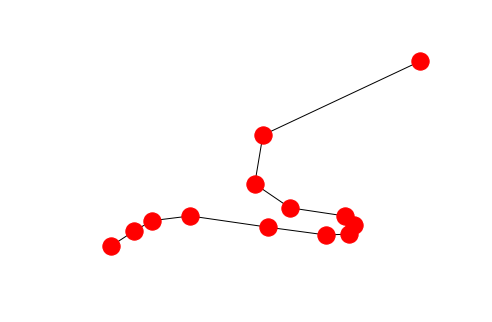

In [7]:
FG = nx.Graph()

positions = {}
for node in Nodes:
    print(node.name)
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)


for edge in Edges:
    print(edge[0].name + ' - ' + edge[1].name)
    FG.add_edge(edge[0].name, edge[1].name, weight = 1)

nx.draw(FG, positions)

### 1.2 Define the project equipment
You can specify a vessel object by entering mix-ins:

    core.Identifiable - enables you to give the object a name
    core.Log - enables you to log all discrete events in which the object is involved
    core.ContainerDependentMovable - A moving container, so capacity and location
    core.Processor - Allow for loading and unloading
    core.HasResource - Add information on serving equipment
    core.HasDepthRestriction - Add information on depth restriction 

#### First create objects with the desired properties

In [8]:
# The generic class for an object that can move and transport (a TSHD for example)
TransportProcessingResource = type('TransportProcessingResource', 
                                   (core.Identifiable,              # Give it a name
                                    core.Log,                       # Allow logging of all discrete events
                                    core.ContainerDependentMovable, # A moving container, so capacity and location
                                    core.Processor,                 # Allow for loading and unloading
                                    core.HasResource,               # Add information on serving equipment
                                    core.Routeable),                 # Initialize spill terms
                                   {})

#### Next specify the properties for vessel(s) you wish to create

In [9]:
# For more realistic simulation you might want to have speed dependent on the volume carried by the vessel
def compute_v_provider(v_empty, v_full):
    return lambda x: x * (v_full - v_empty) + v_empty

def compute_loading(rate):
    return lambda current_level, desired_level: (desired_level - current_level) / rate

def compute_unloading(rate):
    return lambda current_level, desired_level: (current_level - desired_level) / rate

In [10]:
route = []

# TSHD variables
data_hopper = {"env": my_env,                                       # The simpy environment 
               "name": "Hopper 01",                                 # Name
               "geometry": Nodes[0].geometry,                      # It starts at the "from site"
               "loading_func": compute_loading(1.5),                # Loading rate
               "unloading_func": compute_unloading(1.5),            # Unloading rate
               "capacity": 5_000,                                   # Capacity of the hopper - "Beunvolume"
               "compute_v": compute_v_provider(5, 4.5),             # Variable speed
               "route": route}                                      # Graph 

#### Finally create specific instances of the predefined objects with the specified properties

In [11]:
# The simulation object
hopper = TransportProcessingResource(**data_hopper)

### 1.3 Define the activity

In [12]:
# Create activity
activity = model.Activity(env = my_env,           # The simpy environment defined in the first cel
                          name = "Soil movement", # We are moving soil
                          origin = Nodes[0],     # We originate from the from_site
                          destination = Nodes[-1],  # And therefore travel to the to_site
                          loader = hopper,        # The benefit of a TSHD, all steps can be done
                          mover = hopper,         # The benefit of a TSHD, all steps can be done
                          unloader = hopper,      # The benefit of a TSHD, all steps can be done
                          start_condition = None) # We can start right away and do not stop

### 2. Run the simulation

In [13]:
my_env.FG = FG
my_env.run()

print("\n*** Installation of dike finished in {} ***".format(datetime.timedelta(seconds=int(my_env.now - my_env.epoch))))


Time = 2019-03-06 08:31
Start condition is satisfied, Soil movement transporting from Winlocatie to Dumplocatie started.

Time = 2019-03-27 13:37
Stop condition is satisfied, Soil movement transporting from Winlocatie to Dumplocatie completed.

*** Installation of dike finished in 21 days, 5:06:43 ***


### 3. Postprocessing

#### Vessel planning

In [14]:
vessels = [hopper]

activities = ['loading', 'unloading', 'sailing full', 'sailing empty']
colors = {0:'rgb(55,126,184)', 1:'rgb(255,150,0)', 2:'rgb(98, 192, 122)', 3:'rgb(98, 141, 122)'}

plot.vessel_planning(vessels, activities, colors)

#### KML Visualisation

In [15]:
plot.vessel_kml(my_env, vessels, stepsize = 600)
plot.site_kml(my_env, [Nodes[0], Nodes[-1]], stepsize = 600)
# plot.graph_kml(my_env)

In [16]:
# open the file
if platform.system():
    !start ./vessel_movements.kml
    !start ./site_development.kml
else:
    !start explorer ./vessel_movements.kml
    !start explorer ./site_development.kml